# Guidance

This tutorial demonstrates how to perform guidance with a pre-trained diffusion model.

In [1]:
# !git clone --depth 1 --single-branch https://github.com/openai/guided-diffusion
# !pip install datasets

In [2]:
import sys
import torch

sys.path.append("guided-diffusion")

from azula.guidance import DPSSampler, MMPSDenoiser
from azula.plugins import adm
from azula.sample import DDIMSampler
from datasets import load_dataset
from PIL import Image
from torchvision.transforms.functional import resize, to_pil_image, to_tensor

device = "cuda"

In [3]:
_ = torch.manual_seed(0)

## Pre-trained diffusion model

In [4]:
denoiser = adm.load_model("imagenet_256x256_uncond").to(device)

In [5]:
def preprocess(x):
    return 2 * x - 1

In [6]:
def postprocess(x):
    return torch.clip((x + 1) / 2, min=0, max=1)

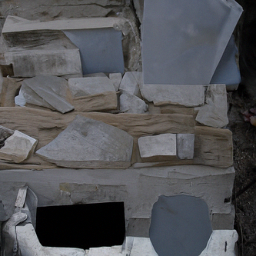

In [7]:
sampler = DDIMSampler(denoiser, steps=64).to(device)

z = torch.randn((1, 3 * 256 * 256), device=device)
x = sampler(z)

to_pil_image(postprocess(x).reshape(3, 256, 256))

## Measurement

In [8]:
def crop(image):
    return image.crop((0, 0, min(image.size), min(image.size))).resize((256, 256))

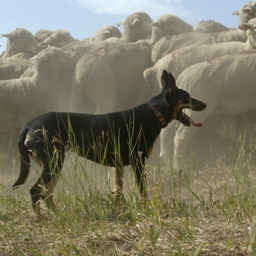

In [9]:
imagenet = load_dataset("ILSVRC/imagenet-1k", streaming=True, split="test", trust_remote_code=True)

x_ref = next(iter(imagenet))["image"]
x_ref = crop(x_ref)
x_ref

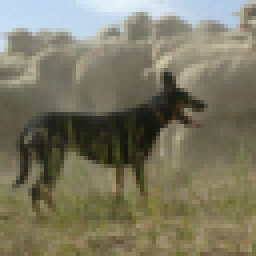

In [10]:
x = preprocess(to_tensor(x_ref))

y = resize(x, (64, 64))
y = y + 0.01 * torch.randn_like(y)

to_pil_image(postprocess(y)).resize((256, 256), Image.NEAREST)

## Diffusion posterior sampling (DPS)

In [11]:
def A(x):
    return resize(x.unflatten(-1, (3, 256, 256)), (64, 64)).flatten(-3)

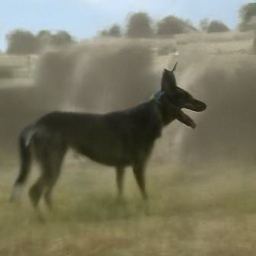

In [12]:
cond_sampler = DPSSampler(denoiser, y=y.flatten(), A=A, zeta=0.5, steps=1000).to(device)

z = torch.randn((1, 3 * 256 * 256), device=device)
x = cond_sampler(z)

to_pil_image(postprocess(x).reshape(3, 256, 256))

## Moment matching posterior sampling (MMPS)

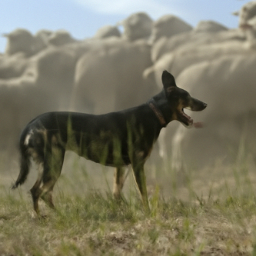

In [13]:
cond_denoiser = MMPSDenoiser(denoiser, y=y.flatten(), A=A, var_y=0.01**2, iterations=3)
cond_sampler = DDIMSampler(cond_denoiser, steps=64).to(device)

z = torch.randn((1, 3 * 256 * 256), device=device)
x = cond_sampler(z)

to_pil_image(postprocess(x).reshape(3, 256, 256))